# VAE pour reconstruction MNIST

Autoencodeur variationnel (VAE) simple, adapté au jeu de données MNIST.  
L’objectif est de bien reconstruire les images d’entrée et d’apprendre un espace latent structuré permettant la génération de nouvelles images.

On reprend l'architecture du code pour "anime faces dataset" et on adapte le modèle.

Il repose maintenant sur une architecture linéaire (MLP), ce qui le rend rapide à entraîner et suffisant pour des images simples comme les chiffres MNIST.

## Import

In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torchvision.utils import save_image


## Paramètres

In [18]:
# Reproductibilité
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

SEED = 28
set_seed(SEED)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

# Hyperparamètres
BATCH_SIZE = 128 #128
EPOCHS = 20 #20
LR = 1e-3
LATENT_DIM = 10 #10

# Sorties
OUT_DIR = "results_ex1_vae_mnist"
os.makedirs(OUT_DIR, exist_ok=True)

Device: cuda


## Split des données

In [19]:
transform = transforms.ToTensor()

full_train = datasets.MNIST(root="dataset", train=True, download=True, transform=transform)

In [20]:
test_set   = datasets.MNIST(root="dataset", train=False, download=True, transform=transform)

In [21]:
train_size = int(0.8 * len(full_train))
val_size = len(full_train) - train_size
train_set, val_set = random_split(full_train, [train_size, val_size])

print(f'Number of images in the training set: {train_size}')
print(f'Number of images in the validation set: {val_size}')

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_set,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_set,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print(f'Number of batches in the training set: {len(train_loader)}')
print(f'Number of batches in the validation set: {len(val_loader)}')

Number of images in the training set: 48000
Number of images in the validation set: 12000
Number of batches in the training set: 375
Number of batches in the validation set: 94


## Encodeur

L’encodeur prend en entrée une image MNIST de taille 28×28, qui est d’abord aplatie en un vecteur de taille 784.  
Ce vecteur est ensuite projeté dans un espace de dimension 400 à l’aide d’une couche linéaire suivie d’une activation ReLU.

À partir de cette représentation, deux couches linéaires distinctes sont utilisées pour estimer :
- la moyenne du vecteur latent,
- la variance (sous forme de log-variance) du vecteur latent.

Ce choix permet de modéliser une distribution gaussienne simple pour la postérieure approchée, tout en restant facile à entraîner.

In [22]:
class Encoder(nn.Module):
    def __init__(self, input_shape=(1,28,28), hidden_dim=400):
        super().__init__()
        c, h, w = input_shape
        self.input_dim = c * h * w  # 784
        self.fc = nn.Linear(self.input_dim, hidden_dim)

    def forward(self, x):
        x = x.view(x.size(0), -1)      # Flatten -> (B,784)
        x = F.relu(self.fc(x))         # (B,400)
        return x

## Bottleneck

Pour pouvoir entraîner le modèle par descente de gradient, l’échantillonnage du vecteur latent est réalisé à l’aide de la fonction sampling qui fait "reparameterization trick".  
Cela permet de séparer l’aspect aléatoire du bruit et les paramètres appris par le réseau, et ainsi de propager correctement les gradients lors de l’entraînement.


In [23]:
class Bottleneck(nn.Module):
    def __init__(self, input_dim=400, latent_dim=10):
        super().__init__()
        self.mu = nn.Linear(input_dim, latent_dim)
        self.logvar = nn.Linear(input_dim, latent_dim)

    def forward(self, x):
        mu = self.mu(x)
        logvar = self.logvar(x)
        z = self.sampling(mu, logvar)
        return mu, logvar, z

    def sampling(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        u = torch.randn_like(std)
        z = mu + u * std
        return z

## Décodeur

Le décodeur reçoit en entrée le vecteur latent échantillonné.  
Il utilise une couche linéaire pour projeter ce vecteur dans un espace de dimension 400, suivie d’une activation ReLU, puis une seconde couche linéaire qui reconstruit un vecteur de taille 784.

Une fonction sigmoïde est appliquée en sortie afin de garantir que les valeurs reconstruites restent comprises entre 0 et 1 comme les images MNIST de bases.


In [24]:
class Decoder(nn.Module):
    def __init__(self, latent_dim=10, hidden_dim=400, output_shape=(1,28,28)):
        super().__init__()
        self.output_shape = output_shape
        c, h, w = output_shape
        self.output_dim = c * h * w  # 784

        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, self.output_dim)

    def forward(self, z):
        x = F.relu(self.fc1(z))            # (B,400)
        x = torch.sigmoid(self.fc2(x))     # (B,784) dans [0,1]
        x = x.view(z.size(0), *self.output_shape)  # (B,1,28,28)
        return x


## VAE

In [25]:
class VAE(nn.Module):
    def __init__(self, input_shape=(1,28,28), hidden_dim=400, latent_dim=10):

        super().__init__()
        self.encoder = Encoder(input_shape=input_shape, hidden_dim=hidden_dim)

        self.bottleneck = Bottleneck(input_dim=hidden_dim, latent_dim=latent_dim)

        self.decoder = Decoder(latent_dim=latent_dim, hidden_dim=hidden_dim, output_shape=input_shape)

    def forward(self, x):

        h = self.encoder(x)

        mu, logvar, z = self.bottleneck(h)

        x_hat = self.decoder(z)

        return x_hat, mu, logvar

## Loss

La loss utilisée est la somme de:
- un terme de reconstruction, mesuré par une erreur quadratique moyenne entre l’image d’entrée et l’image reconstruite = "l'attache aux données";
- un terme de régularisation (KL), qui force la distribution latente apprise à rester proche d’une distribution normale standard.

Un paramètre λ est introduit pour pondérer l’importance du terme de régularisation.  
Cela permet d’étudier le compromis entre qualité de reconstruction et capacité de génération du modèle.


In [26]:
def kl_divergence(mu, logvar):
    # KL = 0.5 * sum(mu^2 + exp(logvar) - 1 - logvar)
    return 0.5 * torch.sum(mu.pow(2) + torch.exp(logvar) - 1.0 - logvar)

def recon_loss_mse(x_hat, x):
    # cohérent avec N(f(z), I)
    return F.mse_loss(x_hat, x, reduction="sum")

def vae_loss(x_hat, x, mu, logvar, lamb=1.0):
    rec = recon_loss_mse(x_hat, x)
    kl  = kl_divergence(mu, logvar)
    return rec + lamb * kl, rec, kl


## Sauvegardes reconstructions / générations à chaque époque

In [ ]:
# aide chat gpt pour les fonction de sauvegarde (images comme demandées sur l'enoncé)
@torch.no_grad()
def save_reconstructions(model, loader, epoch, out_dir, lamb):
    model.eval()
    x, _ = next(iter(loader))
    x = x.to(DEVICE)[:8]
    x_hat, _, _ = model(x)

    # 1ère ligne = test et 2ème ligne = reconstruction
    grid = torch.cat([x, x_hat], dim=0)
    save_image(grid, os.path.join(out_dir, f"lambda_{lamb}_recon_epoch_{epoch:03d}.png"), nrow=8)

@torch.no_grad()
def save_generations(model, epoch, out_dir, lamb, n=16):
    model.eval()
    z = torch.randn(n, LATENT_DIM, device=DEVICE)  # z ~ N(0, I) 
    x_gen = model.decoder(z)
    save_image(x_gen, os.path.join(out_dir, f"lambda_{lamb}_gen_epoch_{epoch:03d}.png"), nrow=4)

## Train dans une fonction pour tester diffférents lambdas

In [28]:
from tqdm import tqdm

def train_one_lambda(lamb=1.0):
    run_dir = os.path.join(OUT_DIR, f"run_lambda_{lamb}")
    os.makedirs(run_dir, exist_ok=True)

    model = VAE(input_shape=(1,28,28), latent_dim=LATENT_DIM, hidden_dim=400).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=LR)

    history = {"train_total": [], "val_total": []}

    for epoch in range(1, EPOCHS + 1) :
        #TRAIN
        model.train()
        train_sum = 0.0

        for x, _ in train_loader:
            x = x.to(DEVICE)
            optimizer.zero_grad()

            x_hat, mu, logvar = model(x)
            loss, rec, kl = vae_loss(x_hat, x, mu, logvar, lamb=lamb)

            loss.backward()
            optimizer.step()
            train_sum += loss.item()

        train_loss = train_sum / len(train_loader.dataset)
        history["train_total"].append(train_loss)

        #VAL
        model.eval()
        val_sum = 0.0
        with torch.no_grad():
            for x, _ in val_loader:
                x = x.to(DEVICE)
                x_hat, mu, logvar = model(x)
                loss, _, _ = vae_loss(x_hat, x, mu, logvar, lamb=lamb)
                val_sum += loss.item()

        val_loss = val_sum / len(val_loader.dataset)
        history["val_total"].append(val_loss)

        print(f"[λ={lamb}] Epoch {epoch}/{EPOCHS} | train={train_loss:.4f} | val={val_loss:.4f}")

        # Sauvegardes
        save_reconstructions(model, test_loader, epoch, run_dir, lamb)
        save_generations(model, epoch, run_dir, lamb, n=16)


    return model, history


In [29]:
import matplotlib.pyplot as plt

def plot_history(history, title="Loss au fil des époques"):
    epochs = range(1, len(history["train_total"]) + 1)

    plt.figure()
    plt.plot(epochs, history["train_total"], label="train_total")
    plt.plot(epochs, history["val_total"], label="val_total")
    plt.xlabel("Epoch")
    plt.ylabel("Loss (par image)")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

## lambda = 1

[λ=1.0] Epoch 1/20 | train=48.9363 | val=40.5726
[λ=1.0] Epoch 2/20 | train=38.6123 | val=36.8896
[λ=1.0] Epoch 3/20 | train=35.7250 | val=34.7691
[λ=1.0] Epoch 4/20 | train=34.0311 | val=33.5915
[λ=1.0] Epoch 5/20 | train=33.0261 | val=32.6015
[λ=1.0] Epoch 6/20 | train=32.3316 | val=32.0796
[λ=1.0] Epoch 7/20 | train=31.8707 | val=31.7384
[λ=1.0] Epoch 8/20 | train=31.5649 | val=31.4401
[λ=1.0] Epoch 9/20 | train=31.2909 | val=31.1742
[λ=1.0] Epoch 10/20 | train=31.0831 | val=31.0679
[λ=1.0] Epoch 11/20 | train=30.9218 | val=30.9036
[λ=1.0] Epoch 12/20 | train=30.7642 | val=30.7048
[λ=1.0] Epoch 13/20 | train=30.6500 | val=30.5925
[λ=1.0] Epoch 14/20 | train=30.5097 | val=30.4998
[λ=1.0] Epoch 15/20 | train=30.4119 | val=30.3349
[λ=1.0] Epoch 16/20 | train=30.3023 | val=30.3594
[λ=1.0] Epoch 17/20 | train=30.1826 | val=30.2834
[λ=1.0] Epoch 18/20 | train=30.1081 | val=30.1916
[λ=1.0] Epoch 19/20 | train=30.0529 | val=30.1425
[λ=1.0] Epoch 20/20 | train=29.9902 | val=30.0926


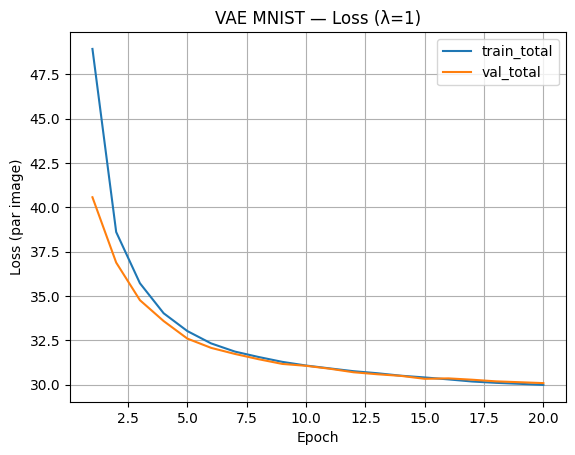

In [30]:
model_1, hist_1 = train_one_lambda(lamb=1.0)
plot_history(hist_1, title="VAE MNIST — Loss (λ=1)")

## lambda = [0.1, 0.5, 5.0]

[λ=0.1] Epoch 1/20 | train=37.2140 | val=22.6468
[λ=0.1] Epoch 2/20 | train=19.3972 | val=17.2239
[λ=0.1] Epoch 3/20 | train=15.9067 | val=14.9809
[λ=0.1] Epoch 4/20 | train=14.3471 | val=13.9119
[λ=0.1] Epoch 5/20 | train=13.4209 | val=13.1363
[λ=0.1] Epoch 6/20 | train=12.8076 | val=12.6646
[λ=0.1] Epoch 7/20 | train=12.3596 | val=12.2981
[λ=0.1] Epoch 8/20 | train=12.0220 | val=12.0242
[λ=0.1] Epoch 9/20 | train=11.7705 | val=11.8402
[λ=0.1] Epoch 10/20 | train=11.5887 | val=11.6615
[λ=0.1] Epoch 11/20 | train=11.4402 | val=11.5105
[λ=0.1] Epoch 12/20 | train=11.2891 | val=11.4283
[λ=0.1] Epoch 13/20 | train=11.2003 | val=11.2906
[λ=0.1] Epoch 14/20 | train=11.0852 | val=11.2076
[λ=0.1] Epoch 15/20 | train=11.0158 | val=11.2007
[λ=0.1] Epoch 16/20 | train=10.9370 | val=11.0836
[λ=0.1] Epoch 17/20 | train=10.8677 | val=11.0513
[λ=0.1] Epoch 18/20 | train=10.8225 | val=11.0389
[λ=0.1] Epoch 19/20 | train=10.7615 | val=10.9703
[λ=0.1] Epoch 20/20 | train=10.7163 | val=10.9161
[λ=0.5] E

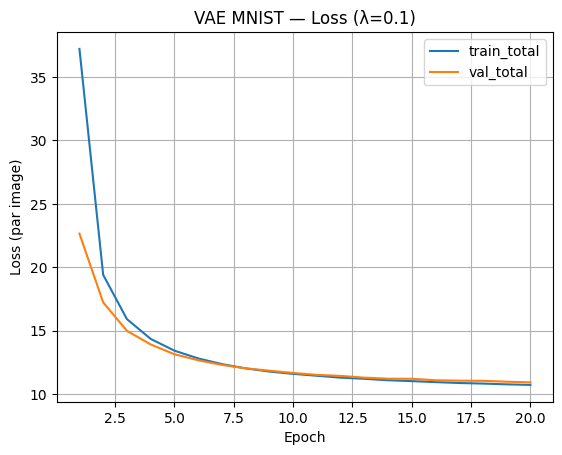

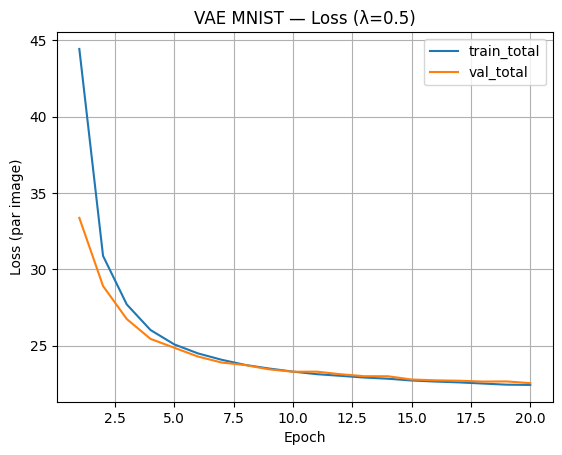

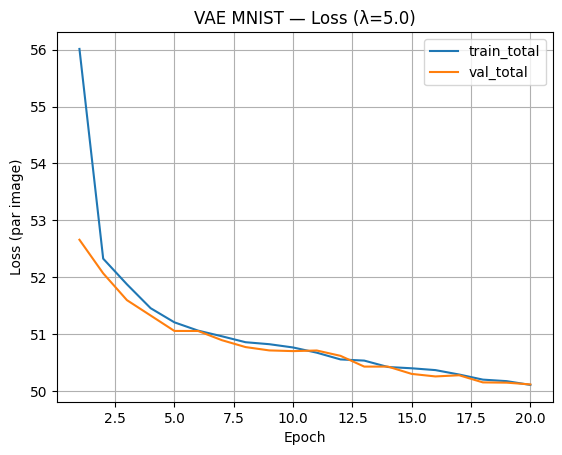

In [31]:
# BONUS : pondérer le KL
lambdas = [0.1, 0.5, 5.0]
model_test = {}
for lam in lambdas:
    model_test[lam] = train_one_lambda(lamb=lam)

for lam, (model_lam, hist_lam) in model_test.items():
    plot_history(hist_lam, title=f"VAE MNIST — Loss (λ={lam})")

## test psnr ssim

METRIQUES POUR LAMBDA = 0.1


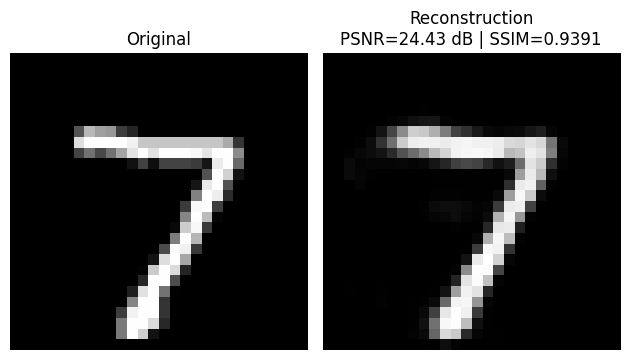

METRIQUES POUR LAMBDA = 0.5


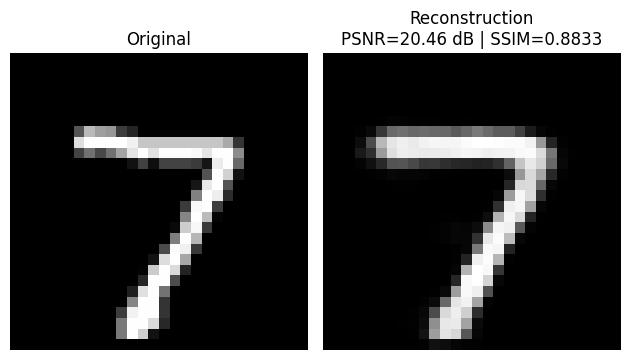

METRIQUES POUR LAMBDA = 5.0


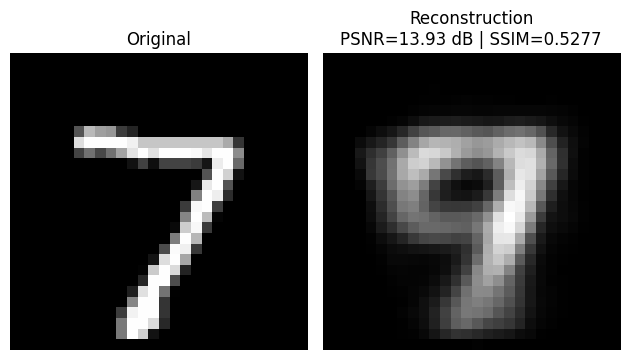

In [32]:
!pip install torchmetrics
from torchmetrics.image import PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure

# 1 image du test
x, _ = next(iter(test_loader))
x = x[:1].to(DEVICE)

for _, lam in enumerate(lambdas):
    print(f"METRIQUES POUR LAMBDA = {lam}")

    model,_ = model_test[lam]
    model.eval()

    with torch.no_grad():
        x_hat, _, _ = model(x)
        x_hat = torch.clamp(x_hat, 0.0, 1.0)

    # Metrics
    psnr_metric = PeakSignalNoiseRatio(data_range=1.0).to(DEVICE)
    ssim_metric = StructuralSimilarityIndexMeasure(data_range=1.0).to(DEVICE)

    psnr_val = psnr_metric(x_hat, x).item()
    ssim_val = ssim_metric(x_hat, x).item()

    # Affichage images
    x_img = x[0,0].detach().cpu().numpy()
    xhat_img = x_hat[0,0].detach().cpu().numpy()

    plt.subplot(1,2,1)
    plt.imshow(x_img, cmap="gray")
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(xhat_img, cmap="gray")
    plt.title(f"Reconstruction\nPSNR={psnr_val:.2f} dB | SSIM={ssim_val:.4f}")
    plt.axis("off")

    plt.tight_layout()
    plt.show()



lambda=0.1 : reconstructions souvent meilleures, mais latent moins régularisé -> générations moins fiables/moins variées.

lambda=0.5 / lambda=1 : compromis reconstruction/génération.

lambda=5 : latent très contraint vers N(0,I)
-> générations plus 'propres', mais reconstructions plus floues.

## Influence des paramètres du modèle

Les performances du VAE dépendent du choix des dimensions et des hyperparamètres.

On remarque que augmenter la dimension intermédiaire ou celle de l’espace latent permet d’améliorer la capacité de représentation du modèle, mais on a un temps de calcul plus élevé.

Le paramètre λ permet d’ajuster le compromis entre reconstruction et génération : une valeur faible favorise des reconstructions fidèles, tandis qu’une valeur plus élevée améliore la structure de l’espace latent et la qualité des images générées.
